In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split,cross_val_score, cross_validate,RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, plot_confusion_matrix
from sklearn.metrics import plot_precision_recall_curve,plot_roc_curve
from scipy import stats
from scipy.stats import uniform

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping

In [2]:
#pip install missingno
# pip install skorch

In [3]:
# Importing our dataset

df = pd.read_csv('water_potability.csv')
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


In [4]:
# World Health Organization has set limits for some of the components in the water to determine the portability.

# They are 
# a) ph = (min:6.5, max:8.5)
# b) Solids = (max:1000)
# c) Chloramines = (max:4)
# d) Sulfate = (range(3,30))
# e) Conductivity = (max:400)
# f) Organic_carbon = (max:2)
# g) Trihalomethanes = (max:80)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


We can see that 3 features has null values and all the features are in same datatype. The target variable is a binary classifier.

### Checking if the Target variable is balanced

Target Variable Balance:
 0    1998
1    1278
Name: Potability, dtype: int64


Text(0.5, 1.0, 'Potability Distribution')

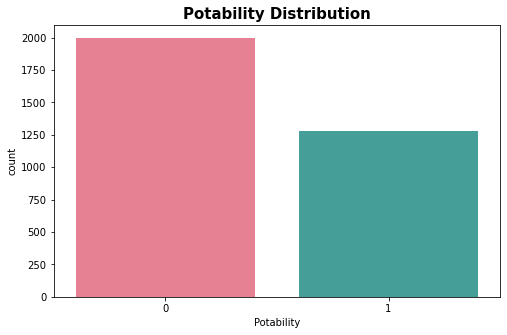

In [6]:
class_balance =df['Potability'].value_counts()
print('Target Variable Balance:\n',class_balance)
plt.figure(figsize=(8,5));
sns.countplot(data = df, x='Potability', palette = 'husl');
plt.title('Potability Distribution',size = 15, weight = 'bold')

Target Variable has a ratio of 61% to 39% ratio. This dataset is not a highly imbalanced dataset. However balancing the target variable may help in our analysis but I am not performing any technique like SMOTE for this analysis

# Handling Missing Values

Null Values:
 ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64


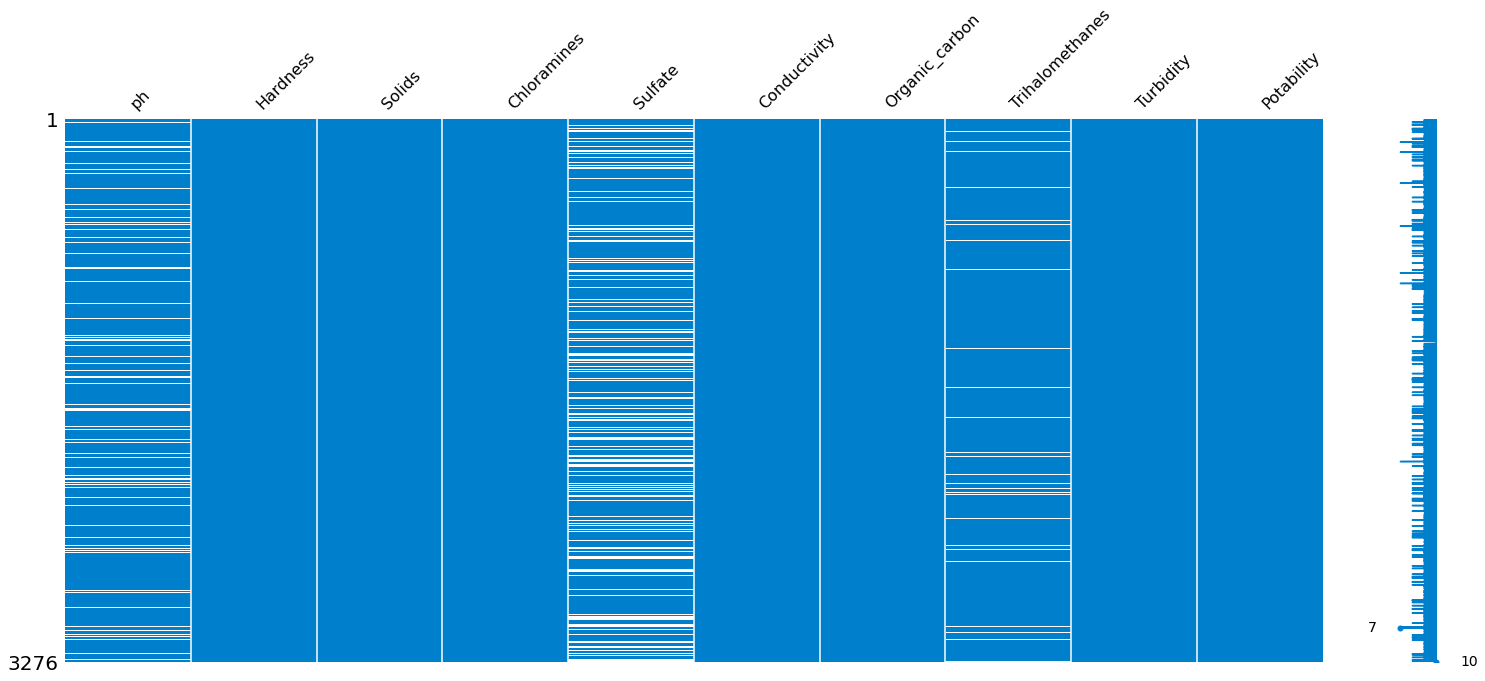

In [7]:
# Lets plot all the missing values
null_info = df.isnull().sum()
fig = msno.matrix(df,color=(0,0.5,0.8))
print('Null Values:\n',null_info)

We have null values in 3 variables. Let's deal with them first. We will check how the values are distributed in these columns

<AxesSubplot:>

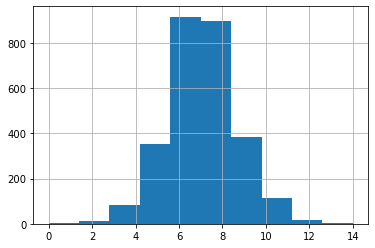

In [8]:
df['ph'].hist()

<AxesSubplot:>

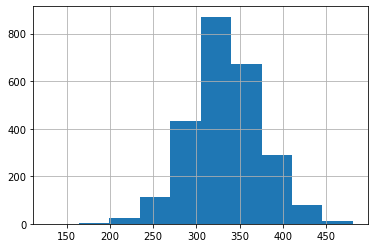

In [9]:
df['Sulfate'].hist()

<AxesSubplot:>

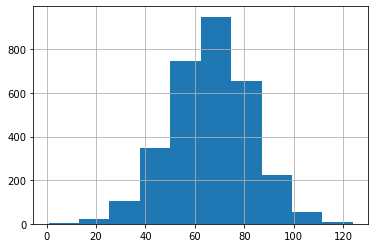

In [10]:
df['Trihalomethanes'].hist()

With the distribution of these columns seen, we can replace the missing values with the mean value.

In [11]:
df['ph'] = df['ph'].fillna(df['ph'].mean())
df['Sulfate'] = df['Sulfate'].fillna(df['Sulfate'].mean())
df['Trihalomethanes'] = df['Trihalomethanes'].fillna(df['Trihalomethanes'].mean())

<AxesSubplot:xlabel='Turbidity', ylabel='ph'>

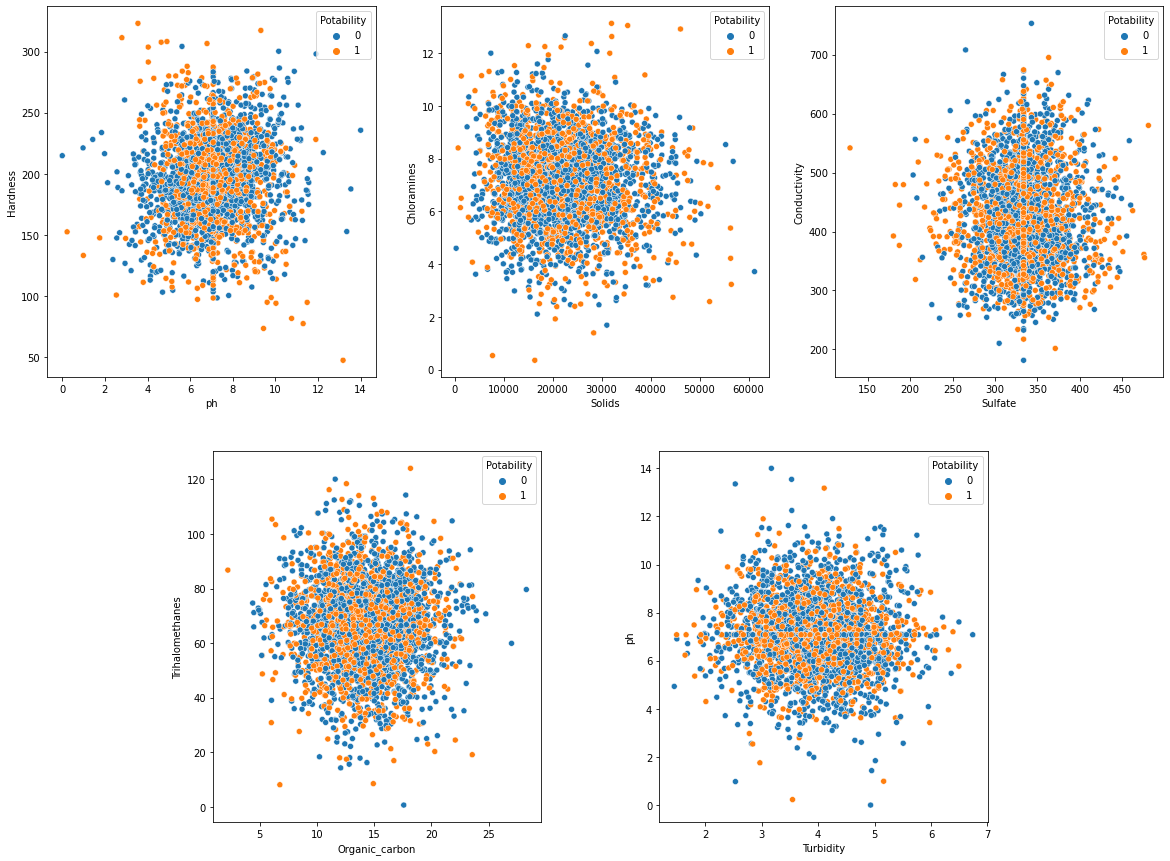

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(20,15));

axes[1, 2].set_visible(False)
axes[1, 0].set_position([0.24,0.125,0.228,0.343])
axes[1, 1].set_position([0.55,0.125,0.228,0.343])

sns.scatterplot(ax=axes[0,0], data = df, x= 'ph',y='Hardness',hue = 'Potability')
sns.scatterplot(ax=axes[0,1], data = df, x= 'Solids',y='Chloramines',hue = 'Potability')
sns.scatterplot(ax=axes[0,2], data = df, x= 'Sulfate',y='Conductivity',hue = 'Potability')
sns.scatterplot(ax=axes[1,0], data = df, x= 'Organic_carbon',y='Trihalomethanes',hue = 'Potability')
sns.scatterplot(ax=axes[1,1], data = df, x= 'Turbidity',y='ph',hue = 'Potability')

In [13]:
# Outliers

In [14]:
z= np.abs(stats.zscore(df))
print(z)

[[8.46038683e-15 2.59194711e-01 1.39470871e-01 ... 1.30614943e+00
  1.28629758e+00 7.99774743e-01]
 [2.28933938e+00 2.03641367e+00 3.85986650e-01 ... 6.38479983e-01
  6.84217891e-01 7.99774743e-01]
 [6.92867789e-01 8.47664833e-01 2.40047337e-01 ... 1.50940884e-03
  1.16736546e+00 7.99774743e-01]
 ...
 [1.59125368e+00 6.26829230e-01 1.27080989e+00 ... 2.18748247e-01
  8.56006782e-01 1.25035206e+00]
 [1.32951593e+00 1.04135450e+00 1.14405809e+00 ... 7.03468419e-01
  9.50797383e-01 1.25035206e+00]
 [5.40150905e-01 3.85462310e-02 5.25811937e-01 ... 7.80223466e-01
  2.12445866e+00 1.25035206e+00]]


In [15]:
print(np.where(z>3))

(array([  37,   61,   66,   80,   88,  104,  140,  245,  253,  263,  263,
        272,  272,  275,  275,  278,  283,  285,  287,  304,  317,  321,
        330,  335,  342,  345,  347,  351,  351,  354,  357,  365,  366,
        379,  382,  383,  385,  434,  492,  509,  531,  546,  666,  680,
        692,  703,  726,  757,  781,  783,  785,  786,  810,  810,  951,
        990, 1031, 1068, 1073, 1075, 1077, 1106, 1123, 1156, 1157, 1186,
       1186, 1290, 1292, 1303, 1316, 1343, 1353, 1360, 1366, 1384, 1412,
       1490, 1523, 1537, 1542, 1554, 1554, 1563, 1605, 1630, 1642, 1743,
       1746, 1766, 1773, 1784, 1792, 1798, 1860, 1892, 1955, 2057, 2075,
       2096, 2121, 2134, 2156, 2189, 2204, 2236, 2302, 2318, 2336, 2343,
       2350, 2353, 2370, 2376, 2401, 2424, 2446, 2447, 2470, 2497, 2602,
       2646, 2646, 2681, 2694, 2699, 2704, 2726, 2757, 2853, 2861, 2868,
       2895, 2899, 2921, 2925, 2928, 2945, 2949, 3014, 3014, 3017, 3020,
       3035, 3042, 3088, 3094, 3130, 3142, 3150, 3

In [16]:
# Actual size of the data before outlier removal
df.shape

(3276, 10)

In [17]:
# Removing outlier which has the z threshold of less than 3
df = df[(z<3).all(axis=1)]

In [18]:
# Shape of the dataset after outlier removal
df.shape

(3128, 10)

<AxesSubplot:>

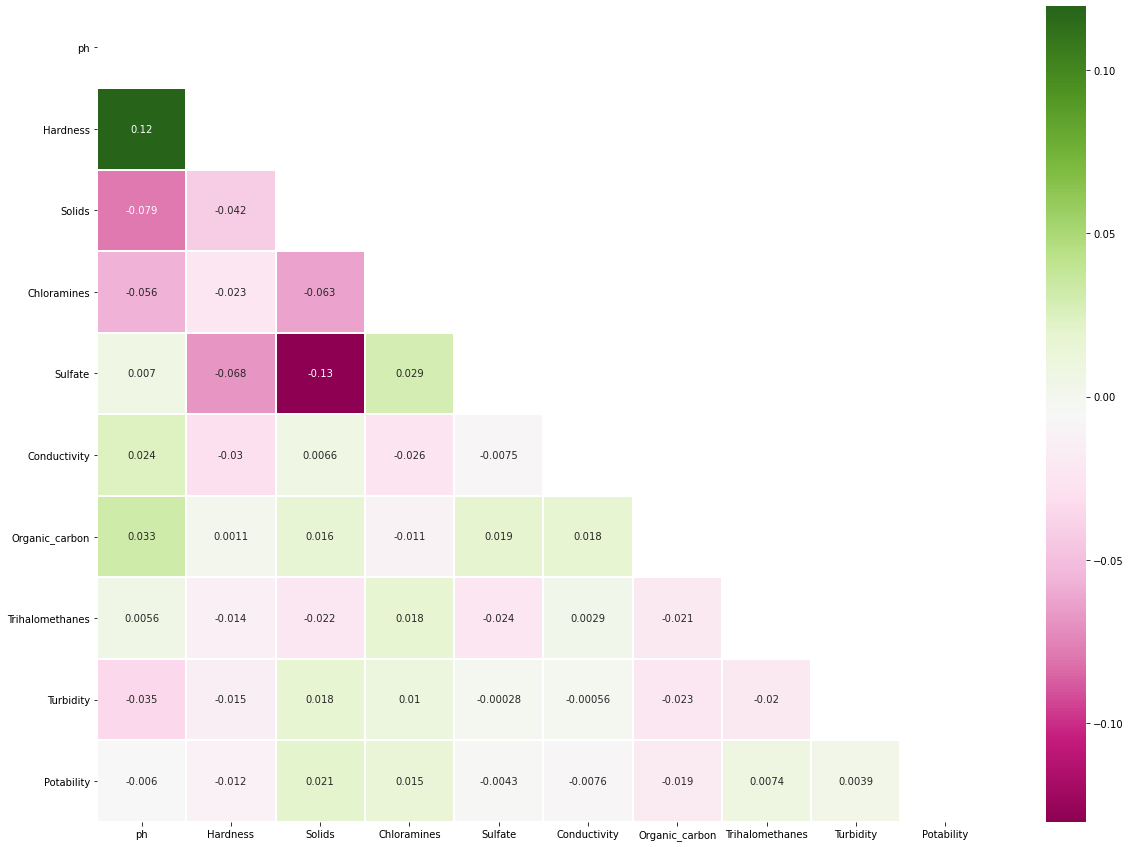

In [19]:
plt.figure(figsize=(20,15))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(),annot=True,linewidth=1,mask=matrix,cmap='PiYG')

# Splitting the data 

In [20]:
# Define our feature variables and the target label
X = df.drop('Potability', axis = 1)
y = df['Potability']

In [21]:
# Split the original Data into training data and the testing data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15, random_state = 42)
X_train.shape,y_train.shape

((2658, 9), (2658,))

In [22]:
# Converting test data into a dataframe
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test)

In [23]:
# Lets keep the test data aside to use this at the end when our models are fully built.
# Export the test data which will be used at the end when our models are ready

X_test_df.to_csv('X_test_data.csv',index = False)
y_test_df.to_csv('y_test_data.csv',index = False)

## Dividing the training data into training and validation data

In [24]:
# With only the training data in hand we will divide them into training and validation sets
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train,y_train, test_size = 0.2, random_state = 42)

In [25]:
# Training shape
X_train_val.shape,y_train_val.shape

((2126, 9), (2126,))

In [26]:
# Validation shape
X_test_val.shape,y_test_val.shape

((532, 9), (532,))

In [27]:
# Confirming if any null values are present
X_train_val.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
dtype: int64

In [28]:
# Rechecking the traget variable balance
y_train_val.value_counts()

0    1303
1     823
Name: Potability, dtype: int64

# Standardization

In [29]:
# Performing standard scale operation to bring all the values into a range of 0 and 1
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train_val)
X_test_scaled = sc.transform(X_test_val)

In [30]:
X_train_scaled

array([[ 1.05920333e+00,  1.85310466e+00,  1.11999381e+00, ...,
        -1.50741074e-01, -2.09148874e+00,  1.39953968e+00],
       [ 5.98924572e-01, -1.90318431e-01, -6.47232702e-01, ...,
         1.03103659e+00,  1.04317855e+00, -1.01199799e-01],
       [-2.35211772e-03, -1.66938656e+00, -2.25767927e-01, ...,
         2.49809306e+00, -8.71059845e-01, -1.37852511e+00],
       ...,
       [-3.85295244e-01, -1.86537519e-01, -7.80309785e-01, ...,
         1.88705487e-01, -3.74631863e-03, -6.79453862e-01],
       [ 1.93642354e+00,  1.51104425e+00, -4.68198669e-01, ...,
         2.86332180e+00,  4.43050221e-01, -2.80714214e-01],
       [-4.60713710e-01, -4.68591906e-01, -4.05164912e-01, ...,
        -1.03040192e-01,  4.92523555e-01, -4.16967611e-02]])

# SVM Model

## Base SVM Model on unscaled data

In [31]:
#Initialize the model
SVC_model = SVC(random_state = 0)

# Fitting the model to our features and labels
SVC_model.fit(X_train_val, y_train_val)

# Traning score for the model
SVC_train_score = SVC_model.score(X_train_val,y_train_val)
print('Initial Training Score :',SVC_train_score)

# Predicting the labels for the test dataset
prediction = SVC_model.predict(X_test_val)

# Calculating the test score
SVC_test_score = accuracy_score(y_test_val, prediction)
print('Initial Testing score:',SVC_test_score)

Initial Training Score : 0.6128880526810913
Initial Testing score: 0.6071428571428571


This score doesn't look descent for a SVM. Maybe as the values are at different ranges

## Base SVM Model on scaled data

In [32]:
#Initialize the model
SVC_scaled_model = SVC()

# Fitting the model to our features and labels
SVC_scaled_model.fit(X_train_scaled, y_train_val)

# Traning score for the model
SVC_scaled_train_score = SVC_scaled_model.score(X_train_scaled,y_train_val)
print('Scaled Training Score :',SVC_scaled_train_score)

# Predicting the labels for the test dataset
scaled_prediction = SVC_scaled_model.predict(X_test_scaled)

# Calculating the test score
SVC_scaled_test_score = accuracy_score(y_test_val, scaled_prediction)
print('Scaled Testing score:',SVC_scaled_test_score)

Scaled Training Score : 0.7309501411100658
Scaled Testing score: 0.6654135338345865


This data looks decent but not a good result.

### Classification Report after scaling

In [33]:
print(classification_report(y_test_val,scaled_prediction, zero_division = True))

              precision    recall  f1-score   support

           0       0.66      0.94      0.77       323
           1       0.73      0.23      0.36       209

    accuracy                           0.67       532
   macro avg       0.69      0.59      0.56       532
weighted avg       0.69      0.67      0.61       532



### Confusion Matrix after scaling

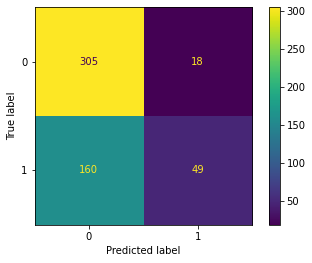

In [34]:
# SVC_matrix_scaled = confusion_matrix(y_test_val,scaled_prediction)
plot_confusion_matrix(SVC_scaled_model,X_test_scaled,y_test_val);

### ROC Curve and AUC 

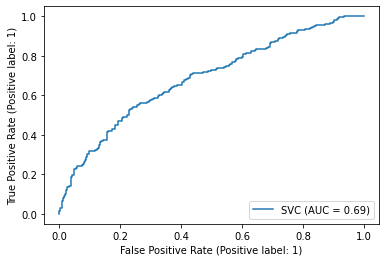

In [35]:
plot_roc_curve(SVC_scaled_model,X_test_scaled,y_test_val);

Lets us see if cross validation improves the performance of the our scaled initial model

### Applying Cross Validation and checking the average of the values to see if it has better performance

In [36]:
# Performing 10 fold cross validation
SVC_cv_model = SVC()
SVC_cv_scores = cross_validate(SVC_cv_model, X_train_scaled, y_train_val,scoring = ['accuracy','precision_weighted','recall_weighted','f1_weighted'], cv = 10)
SVC_cv_scores = pd.DataFrame(SVC_cv_scores, index = range(1,11))
SVC_cv_scores

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
1,0.174599,0.031289,0.657277,0.656671,0.657277,0.604288
2,0.172754,0.031122,0.680751,0.695693,0.680751,0.633074
3,0.170608,0.031123,0.699531,0.712647,0.699531,0.663402
4,0.170795,0.030848,0.591549,0.540197,0.591549,0.521474
5,0.172133,0.031095,0.680751,0.703604,0.680751,0.631241
6,0.192547,0.030896,0.666667,0.664411,0.666667,0.629273
7,0.170096,0.030916,0.636792,0.635091,0.636792,0.558936
8,0.171281,0.030609,0.669811,0.682864,0.669811,0.617157
9,0.169358,0.030581,0.674528,0.694213,0.674528,0.620828
10,0.170230,0.030838,0.655660,0.650378,0.655660,0.609603


In [37]:
CV_score = SVC_cv_scores.mean()['test_accuracy']
print('10 Fold cross validation accuracy:',CV_score)

10 Fold cross validation accuracy: 0.6613318274426433


It has decresed our accuracy as most of validation sets resulted in low performance than expected. 

We haven't choosed any of the parameters as of now while valuating the performance of the model. Let's try parameter tuning to check if it improve the prediction power

## Hyperparameter Tuning for SVC model

Let us try Random Search method to find the best parameter set in the plane.

### Random Search CV

In [38]:
%%time

SVC_random_model = SVC()

parameters = {'C':[0.5,1.2,1.5,1.7,2.5,5,10],
              'kernel': ['rbf','sigmoid'],
              'gamma':['auto','scale']
             }

random_search = RandomizedSearchCV(estimator = SVC_random_model,
                                   param_distributions = parameters,
                                   cv=3)
random_search.fit(X_train_scaled, y_train_val)
sheet = pd.DataFrame(random_search.cv_results_)
sheet[['param_C','param_kernel','param_gamma','mean_test_score']].sort_values(by =['mean_test_score'])


CPU times: user 4.42 s, sys: 15.2 ms, total: 4.43 s
Wall time: 4.44 s


,param_C,param_kernel,param_gamma,mean_test_score
7,10,sigmoid,scale,0.511294
9,5,sigmoid,scale,0.526351
5,2.5,sigmoid,auto,0.539053
1,1.7,sigmoid,scale,0.546574
3,1.5,sigmoid,scale,0.554101
4,10,rbf,auto,0.647696
0,5,rbf,scale,0.654282
8,1.7,rbf,scale,0.656162
6,0.5,rbf,auto,0.656633
2,1.7,rbf,auto,0.658043


It has been observed that each kernel can choose its parameters easily. Hence each kernel is taken once at a time. And Linear kernel takes a longer time than usual to fit the datapoints. Hence this kernel is skipped in this analysis.

In [39]:
# Best parameters
random_search.best_params_

{'kernel': 'rbf', 'gamma': 'auto', 'C': 1.7}

In [40]:
#Let's check how our best parameters perform on our model
random_model = SVC(C= 1.7,gamma = 'auto', kernel = 'rbf')
# Fit the model to our data
random_model.fit(X_train_scaled,y_train_val)
train_random_score=random_model.score(X_train_scaled,y_train_val)
# Calculating the training score
print('Random Training Score :',train_random_score)

# Performing predictions
test_random_predict = random_model.predict(X_test_scaled)
test_random_score = accuracy_score(y_test_val, test_random_predict)

# Calculating the test score
print('Random Testing score:',test_random_score)

Random Training Score : 0.7587017873941675
Random Testing score: 0.6616541353383458


In [41]:
%%time

SVC_random_model = SVC()

parameters = {'C':[0.5,1.2,1.5,1.7,2.5,5,10],
              'kernel': ['poly'],
              'gamma':['auto','scale'],
              'degree':[3,4,5]
             }

random_search2 = RandomizedSearchCV(estimator = SVC_random_model,
                                   param_distributions = parameters,
                                   cv=3)
random_search2.fit(X_train_scaled, y_train_val)
sheet = pd.DataFrame(random_search2.cv_results_)
sheet[['param_C','param_kernel','param_gamma','mean_test_score']].sort_values(by =['mean_test_score'])

CPU times: user 3.43 s, sys: 8.08 ms, total: 3.44 s
Wall time: 3.44 s


,param_C,param_kernel,param_gamma,mean_test_score
6,1.5,poly,auto,0.608185
3,2.5,poly,scale,0.610064
0,1.2,poly,scale,0.615710
4,0.5,poly,auto,0.619000
8,0.5,poly,scale,0.619000
2,0.5,poly,scale,0.619004
7,10,poly,auto,0.622293
1,2.5,poly,scale,0.644409
9,1.7,poly,scale,0.646758
5,1.5,poly,auto,0.647229


In [42]:
# Best parameters
random_search2.best_params_

{'kernel': 'poly', 'gamma': 'auto', 'degree': 4, 'C': 1.5}

In [43]:
#Let's check how our best parameters perform on our model
random_model2 = SVC(C= 1.2,gamma = 'scale',degree = 4, kernel = 'poly')
# Fit the model to our data
random_model2.fit(X_train_scaled,y_train_val)
train_random_score2=random_model2.score(X_train_scaled,y_train_val)
# Calculating the training score
print('Random2 Training Score :',train_random_score2)

# Performing predictions
test_random_predict2 = random_model2.predict(X_test_scaled)
test_random_score2 = accuracy_score(y_test_val, test_random_predict2)

# Calculating the test score
print('Random2 Testing score:',test_random_score2)

Random2 Training Score : 0.746472248353716
Random2 Testing score: 0.674812030075188


# Using Grid Search to find the Hyperparameters

First we will try using rbf, linear and sigmoid kernel.(This method is used as polynomial kernal combined with other kernal yeild huge amount time to converge with the given set of parameters.)

In [44]:
%%time

SVC_grid_model = SVC()

parameters = {'C':[0.5,1.2,1.5,1.7,2.5,5,10],
              'kernel': ['rbf','sigmoid','linear'],
              'gamma':['auto','scale']
             }


grid_search = GridSearchCV(estimator = SVC_grid_model,
                           param_grid = parameters,
                           cv=5)

grid_search.fit(X_train_scaled, y_train_val)


sheet = pd.DataFrame(grid_search.cv_results_)
sheet[['param_C','param_kernel','param_gamma','mean_test_score']].sort_values(by =['mean_test_score'])

CPU times: user 32 s, sys: 134 ms, total: 32.1 s
Wall time: 32.2 s


,param_C,param_kernel,param_gamma,mean_test_score
37,10,sigmoid,auto,0.525404
40,10,sigmoid,scale,0.535755
31,5,sigmoid,auto,0.536223
25,2.5,sigmoid,auto,0.538583
34,5,sigmoid,scale,0.539992
19,1.7,sigmoid,auto,0.539994
22,1.7,sigmoid,scale,0.542814
28,2.5,sigmoid,scale,0.546107
13,1.5,sigmoid,auto,0.547046
10,1.2,sigmoid,scale,0.548925


In [45]:
grid_search.best_params_

{'C': 1.5, 'gamma': 'scale', 'kernel': 'rbf'}

In [46]:
grid_model = SVC(C= 1.5,gamma = 'scale', kernel = 'rbf')
# Perform fit
grid_model.fit(X_train_scaled,y_train_val)
train_grid_score=grid_model.score(X_train_scaled,y_train_val)
# Calculating the training score
print('Grid Training Score:',train_grid_score)

# Making predictions
test_grid_p = grid_model.predict(X_test_scaled)
test_grid_score = accuracy_score(y_test_val, test_grid_p)

# Calculating the test score
print('Grid Testing score:',test_grid_score)

Grid Training Score: 0.7525870178739417
Grid Testing score: 0.6578947368421053


Now lets try Grid search on polynomial function and see if it has good solution to our problem.

In [47]:
%%time

SVC_grid_model = SVC()

parameters = {'C':[0.5,1.2,1.5,1.7,2.5,5,10],
              'kernel': ['poly'],
              'gamma':['auto','scale'],
              'degree':[3,4,5]
             }


grid_search2 = GridSearchCV(estimator = SVC_grid_model,
                           param_grid = parameters,
                           cv=5)

grid_search2.fit(X_train_scaled, y_train_val)


sheet = pd.DataFrame(grid_search2.cv_results_)
sheet[['param_C','param_kernel','param_gamma','mean_test_score']].sort_values(by =['mean_test_score'])

CPU times: user 36 s, sys: 110 ms, total: 36.1 s
Wall time: 36.1 s


,param_C,param_kernel,param_gamma,mean_test_score
41,10,poly,scale,0.595009
40,10,poly,auto,0.595009
34,5,poly,auto,0.606766
35,5,poly,scale,0.607237
23,1.7,poly,scale,0.608653
22,1.7,poly,auto,0.608653
28,2.5,poly,auto,0.608654
37,10,poly,scale,0.608662
36,10,poly,auto,0.609131
29,2.5,poly,scale,0.609593


In [48]:
grid_search2.best_params_

{'C': 1.2, 'degree': 4, 'gamma': 'auto', 'kernel': 'poly'}

Applying this parameters to our model to check the performance.

In [49]:
grid_model2 = SVC(C= 1.2,gamma = 'auto',degree = 4,kernel = 'poly')
# Fit the data
grid_model2.fit(X_train_scaled,y_train_val)
train_grid_score2=grid_model2.score(X_train_scaled,y_train_val)
# Calculating the training score
print('Grid Training Score2 :',train_grid_score2)

# Performing predictions
test_grid_predict2 = grid_model2.predict(X_test_scaled)
test_grid_score2 = accuracy_score(y_test_val, test_grid_predict2)

# Calculating the test score
print('Grid Testing Score2:',test_grid_score2)

Grid Training Score2 : 0.746472248353716
Grid Testing Score2: 0.674812030075188


From the above two models we can choose Grid Search model with polynomial kernel as our final parameters

In [50]:
final_parameters = {'C':[1.2],
              'kernel': ['poly'],
              'gamma':['auto'],
              'degree':[4]
             }

### Best Model

 Building the best model with the parameters which were identified as best

In [51]:
%%time

best_SVC_model = SVC(C= 1.2,gamma = 'scale', kernel = 'poly',degree= 4)
# Fitting our data
best_SVC_model.fit(X_train_scaled,y_train_val)
train_best_SVC_score=best_SVC_model.score(X_train_scaled,y_train_val)
# Calculating the training score
print('Training Score :',train_best_SVC_score)

test_best_predict= best_SVC_model.predict(X_test_scaled)
test_best_score = accuracy_score(y_test_val, test_best_predict)

# Calculating the test score
print('Testing score:',test_best_score)

Training Score : 0.746472248353716
Testing score: 0.674812030075188
CPU times: user 288 ms, sys: 4.62 ms, total: 292 ms
Wall time: 292 ms


In [52]:
print(classification_report(y_test_val,test_best_predict, zero_division = True))

              precision    recall  f1-score   support

           0       0.67      0.93      0.78       323
           1       0.71      0.29      0.41       209

    accuracy                           0.67       532
   macro avg       0.69      0.61      0.59       532
weighted avg       0.69      0.67      0.63       532



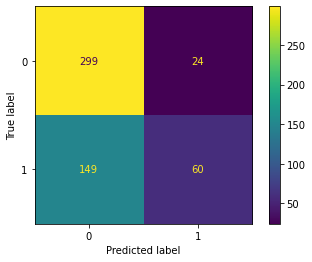

In [53]:
plot_confusion_matrix(best_SVC_model,X_test_scaled,y_test_val)

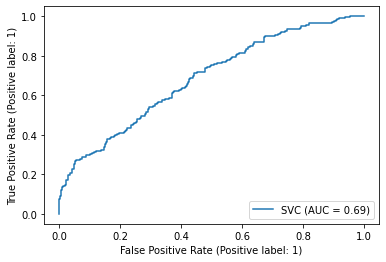

In [54]:
plot_roc_curve(best_SVC_model,X_test_scaled,y_test_val)

Our final model is ready and is ready to apply on our test data set. The name of the final model is best_SVC_model

# MLP Model

Converting our variables data into a tensor

In [55]:
X_train_scaled = torch.tensor(X_train_scaled)
X_test_scaled = torch.tensor(X_test_scaled)
X_train_scaled.shape


torch.Size([2126, 9])

In [56]:
y_train_val = torch.tensor(np.array(y_train_val))
y_train_val.shape

torch.Size([2126])

### We will define the initial parameters needed for our multilayer perceptron

In [57]:
input_dim = X_train_scaled.shape[1]
# Let us start with nominal hidden nodes in our network
hidden_dim = 100
output_dim = 2
# Dropout can be choosen randomly but most famous is half of the data samples
dropout = 0.5
# Many activation functions such as sigmoid, tanh, relu,Leaky relu etc are available and Relu is my first choice
activation = F.relu
device ='cpu'

In [58]:
print('Input Size:',input_dim,
      'Hidden Size:', hidden_dim,
      'Output Size:',output_dim)

Input Size: 9 Hidden Size: 100 Output Size: 2


### Building a basic neural network

In [59]:
# This network was build with the reference of Turorial 2 from the labs.
class MLP(nn.Module):
    def __init__(
            self,
            input_size = input_dim,
            hidden_size = hidden_dim,
            output_size = output_dim,
            dropout = dropout,
            activation = activation
    ):
        super(MLP, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.activation = activation
        # The first layer will pass the input values of 9 dimension into the hidden layer which has a size of 100
        self.fc1 = nn.Linear(input_size, hidden_size)
        # The Second layer has one more hidden layer with 100 nodes
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        # The result from the hidden layer will be connected to the output function
        self.output_size = nn.Linear(hidden_size, output_size)
        
    def forward(self, X):
        X = self.activation(self.fc1(X))
        X = self.dropout(X)
        X = self.activation(self.fc2(X))
        X = self.dropout(X)
        X = F.softmax(self.output_size(X), dim = -1)
        
        return X

Building a model using the network

In [60]:
torch.manual_seed(0)

MLP_model = NeuralNetClassifier(
    MLP,
    max_epochs = 20,
    lr = 0.1,
    device = device)

In [61]:
X_train_scaled_tensor = X_train_scaled.type(torch.LongTensor)

Fit the model into our dataset

In [62]:
MLP_model.fit(X_train_scaled_tensor.float(), y_train_val)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6828       0.6127        0.6717  0.0923
      2        0.6756       0.6127        0.6708  0.0268
      3        0.6694       0.6127        0.6696  0.0272
      4        0.6702       0.6127        0.6684  0.0273
      5        0.6704       0.6127        0.6681  0.0268
      6        0.6655       0.6127        0.6672  0.0274
      7        0.6679       0.6127        0.6668  0.0272
      8        0.6676       0.6127        0.6664  0.0272
      9        0.6662       0.6127        0.6658  0.0264
     10        0.6658       0.6127        0.6654  0.0277
     11        0.6659       0.6127        0.6647  0.0263
     12        0.6680       0.6127        0.6644  0.0267
     13        0.6672       0.6127        0.6639  0.0269
     14        0.6655       0.6127        0.6639  0.0268
     15        0.6680       0.6127        0.6635  0.0273
     16        0.6623       0.6

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MLP(
    (dropout): Dropout(p=0.5, inplace=False)
    (fc1): Linear(in_features=9, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
    (output_size): Linear(in_features=100, out_features=2, bias=True)
  ),
)

 We con observe that the initial training accuracy is 62.21

In [63]:
X_train_scaled = X_train_scaled.float()
X_test_scaled = X_test_scaled.float()

Let us use this model to predict our target variables and see the predictions on the validation data

In [64]:
mlp_pred = MLP_model.predict(X_test_scaled)

mlp_pred_score = accuracy_score(y_test_val, mlp_pred)

print('Initial Testing Score:',mlp_pred_score)

Initial Testing Score: 0.6109022556390977


In [65]:
print(classification_report(y_test_val,mlp_pred, zero_division = True))

              precision    recall  f1-score   support

           0       0.61      0.99      0.76       323
           1       0.67      0.02      0.04       209

    accuracy                           0.61       532
   macro avg       0.64      0.51      0.40       532
weighted avg       0.63      0.61      0.47       532



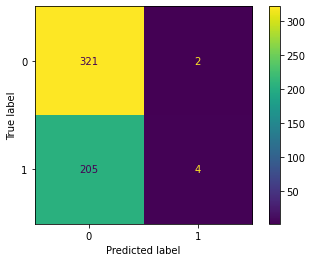

In [66]:
plot_confusion_matrix(MLP_model,X_test_scaled,y_test_val)

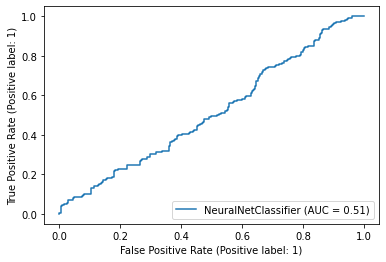

In [67]:
plot_roc_curve(MLP_model,X_test_scaled,y_test_val)

Early Stopping is found to be useful many scenarios. Hence we will try this on our model

In [68]:
MLP_model = NeuralNetClassifier(
    MLP,
    lr = 0.1,
    max_epochs = 100,
    callbacks = [EarlyStopping()]
    )

In [69]:
MLP_model.fit(X_train_scaled,y_train_val)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6741       0.6127        0.6685  0.0266
      2        0.6713       0.6127        0.6671  0.0279
      3        0.6700       0.6127        0.6657  0.0275
      4        0.6730       0.6127        0.6655  0.0279
      5        0.6676       0.6127        0.6639  0.0297
      6        0.6688       0.6127        0.6630  0.0276
      7        0.6652       0.6150        0.6626  0.0272
      8        0.6660       0.6150        0.6620  0.0271
      9        0.6607       0.6150        0.6611  0.0269
     10        0.6699       0.6150        0.6600  0.0275
     11        0.6634       0.6150        0.6592  0.0272
     12        0.6637       0.6127        0.6578  0.0278
     13        0.6610       0.6150        0.6576  0.0270
     14        0.6623       0.6127        0.6563  0.0276
     15        0.6573       0.6150        0.6548  0.0273
     16        0.6612       0.6

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MLP(
    (dropout): Dropout(p=0.5, inplace=False)
    (fc1): Linear(in_features=9, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
    (output_size): Linear(in_features=100, out_features=2, bias=True)
  ),
)

In [70]:
# By using early stopping, the testing accuracy has improved to 66.67

In [71]:
mlp_pred = MLP_model.predict(X_test_scaled)

mlp_pred_score = accuracy_score(y_test_val, mlp_pred)

print('Testing Score after using Early Stopping:',mlp_pred_score)

Testing Score after using Early Stopping: 0.6522556390977443


It indeed increased the performance of our model.

Lets Check if Cross Validation can improve our model.

In [72]:
scores = cross_validate(MLP_model, X_train_scaled, y_train_val, scoring = 'accuracy', cv =10)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6786       0.6136        0.6684  0.0234
      2        0.6749       0.6136        0.6658  0.0239
      3        0.6772       0.6136        0.6641  0.0240
      4        0.6711       0.6136        0.6634  0.0241
      5        0.6679       0.6136        0.6616  0.0241
      6        0.6685       0.6136        0.6604  0.0239
      7        0.6640       0.6136        0.6593  0.0244
      8        0.6695       0.6136        0.6588  0.0252
      9        0.6656       0.6136        0.6577  0.0241
     10        0.6638       0.6136        0.6573  0.0243
     11        0.6659       0.6136        0.6576  0.0247
     12        0.6613       0.6136        0.6568  0.0239
     13        0.6617       0.6136        0.6560  0.0239
     14        0.6623       0.6136        0.6547  0.0237
     15        0.6638       0.6162        0.6536  0.0242
     16        0.6602       0.6

     53        0.6340       0.6580        0.6206  0.0236
     54        0.6353       0.6580        0.6202  0.0233
     55        0.6378       0.6606        0.6202  0.0230
     56        0.6335       0.6632        0.6186  0.0230
     57        0.6401       0.6606        0.6178  0.0227
     58        0.6397       0.6606        0.6170  0.0228
     59        0.6313       0.6580        0.6158  0.0226
     60        0.6431       0.6606        0.6165  0.0222
     61        0.6357       0.6632        0.6168  0.0224
     62        0.6298       0.6632        0.6158  0.0224
     63        0.6335       0.6710        0.6145  0.0224
     64        0.6334       0.6736        0.6141  0.0224
     65        0.6352       0.6736        0.6136  0.0224
     66        0.6359       0.6762        0.6135  0.0227
     67        0.6347       0.6789        0.6130  0.0224
     68        0.6396       0.6762        0.6130  0.0224
     69        0.6265       0.6762        0.6118  0.0223
     70        0.6249       0.6

      5        0.6658       0.6136        0.6680  0.0228
      6        0.6668       0.6136        0.6671  0.0224
      7        0.6623       0.6136        0.6662  0.0227
      8        0.6617       0.6136        0.6659  0.0222
      9        0.6610       0.6136        0.6651  0.0223
     10        0.6573       0.6136        0.6644  0.0226
     11        0.6626       0.6188        0.6634  0.0223
     12        0.6621       0.6136        0.6632  0.0224
     13        0.6611       0.6214        0.6623  0.0222
     14        0.6626       0.6214        0.6613  0.0221
     15        0.6615       0.6214        0.6614  0.0225
     16        0.6557       0.6188        0.6612  0.0222
     17        0.6582       0.6188        0.6604  0.0230
     18        0.6595       0.6188        0.6593  0.0221
     19        0.6604       0.6214        0.6582  0.0224
     20        0.6562       0.6214        0.6578  0.0223
     21        0.6599       0.6188        0.6573  0.0223
     22        0.6530       0.6

     47        0.6351       0.6606        0.6282  0.0229
     48        0.6332       0.6632        0.6282  0.0226
     49        0.6341       0.6632        0.6277  0.0225
     50        0.6352       0.6632        0.6269  0.0223
     51        0.6339       0.6632        0.6255  0.0225
     52        0.6300       0.6632        0.6251  0.0228
     53        0.6291       0.6632        0.6240  0.0227
     54        0.6222       0.6658        0.6231  0.0232
     55        0.6210       0.6658        0.6220  0.0232
     56        0.6275       0.6658        0.6239  0.0232
     57        0.6275       0.6632        0.6230  0.0233
     58        0.6365       0.6658        0.6222  0.0230
     59        0.6289       0.6684        0.6215  0.0234
     60        0.6282       0.6658        0.6200  0.0226
     61        0.6222       0.6632        0.6199  0.0235
     62        0.6190       0.6710        0.6184  0.0232
     63        0.6253       0.6632        0.6187  0.0234
     64        0.6246       0.6

     17        0.6586       0.6188        0.6572  0.0240
     18        0.6554       0.6188        0.6568  0.0226
     19        0.6527       0.6188        0.6564  0.0228
     20        0.6625       0.6214        0.6557  0.0225
     21        0.6552       0.6240        0.6556  0.0226
     22        0.6558       0.6240        0.6539  0.0225
     23        0.6557       0.6240        0.6539  0.0227
     24        0.6608       0.6240        0.6535  0.0226
     25        0.6540       0.6240        0.6528  0.0227
     26        0.6567       0.6240        0.6519  0.0230
     27        0.6561       0.6214        0.6522  0.0232
     28        0.6542       0.6319        0.6505  0.0231
     29        0.6477       0.6345        0.6484  0.0233
     30        0.6546       0.6345        0.6494  0.0232
     31        0.6513       0.6345        0.6493  0.0233
     32        0.6444       0.6292        0.6489  0.0230
     33        0.6512       0.6292        0.6484  0.0237
     34        0.6523       0.6

     41        0.6427       0.6501        0.6363  0.0235
     42        0.6472       0.6475        0.6355  0.0231
     43        0.6425       0.6475        0.6350  0.0235
     44        0.6410       0.6475        0.6347  0.0232
     45        0.6358       0.6501        0.6350  0.0229
     46        0.6397       0.6501        0.6340  0.0231
     47        0.6458       0.6527        0.6346  0.0229
     48        0.6372       0.6527        0.6332  0.0232
     49        0.6335       0.6449        0.6326  0.0234
     50        0.6473       0.6554        0.6324  0.0230
     51        0.6347       0.6527        0.6324  0.0226
     52        0.6368       0.6554        0.6314  0.0223
     53        0.6410       0.6554        0.6309  0.0225
     54        0.6321       0.6554        0.6307  0.0223
     55        0.6392       0.6580        0.6291  0.0228
     56        0.6332       0.6632        0.6285  0.0224
     57        0.6350       0.6554        0.6286  0.0228
     58        0.6393       0.6

     73        0.6267       0.6580        0.6154  0.0231
     74        0.6172       0.6554        0.6151  0.0229
     75        0.6234       0.6554        0.6147  0.0228
     76        0.6233       0.6554        0.6145  0.0229
     77        0.6240       0.6554        0.6149  0.0231
     78        0.6201       0.6554        0.6144  0.0228
     79        0.6321       0.6580        0.6147  0.0231
     80        0.6190       0.6580        0.6146  0.0234
     81        0.6211       0.6580        0.6140  0.0234
     82        0.6165       0.6632        0.6133  0.0235
     83        0.6192       0.6606        0.6136  0.0235
     84        0.6233       0.6580        0.6144  0.0233
     85        0.6260       0.6580        0.6147  0.0233
     86        0.6159       0.6606        0.6136  0.0229
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6824  

In [73]:
from statistics import mean
for measure,values in scores.items():
    print("Average for {} is {}".format(measure,mean(values)))

Average for fit_time is 1.9135855674743651
Average for score_time is 0.0023204803466796873
Average for test_score is 0.655219682877137


From the scores of the cross validation process, we can observe that the performance of the model has increased on an average.

# MLP Hyperparameter Optimization

In [74]:
# Setting a base model without any parameters

criterion = nn.CrossEntropyLoss()
MLP_model = NeuralNetClassifier(
    MLP,
    criterion = criterion,
    callbacks = [EarlyStopping()]
    )

## Using Random Search to find the best parameters

In [75]:
%%time
MLP_model.set_params(verbose=0)

params = {   'lr': [0.0001,0.001,0.01],
             'batch_size': [250,300,350],
             'optimizer':[optim.Adam, optim.SGD],
             'module__hidden_size': [50,100,200],
             'module__dropout': [0.2,0.3,0.5],
             'max_epochs': [200,400,500]
         }

random_MLP = RandomizedSearchCV(MLP_model,
                                params,
                                cv=3,
                                scoring = 'accuracy')

random_MLP.fit(X_train_scaled, y_train_val)

CPU times: user 1min 31s, sys: 1.72 s, total: 1min 32s
Wall time: 1min 30s


RandomizedSearchCV(cv=3,
                   estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.MLP'>,
),
                   param_distributions={'batch_size': [250, 300, 350],
                                        'lr': [0.0001, 0.001, 0.01],
                                        'max_epochs': [200, 400, 500],
                                        'module__dropout': [0.2, 0.3, 0.5],
                                        'module__hidden_size': [50, 100, 200],
                                        'optimizer': [<class 'torch.optim.adam.Adam'>,
                                                      <class 'torch.optim.sgd.SGD'>]},
                   scoring='accuracy')

In [76]:
random_MLP.best_score_, random_MLP.best_params_

(0.6651008422780553,
 {'optimizer': torch.optim.adam.Adam,
  'module__hidden_size': 200,
  'module__dropout': 0.5,
  'max_epochs': 400,
  'lr': 0.0001,
  'batch_size': 250})

In [77]:
MLP_random_pred = random_MLP.predict(X_test_scaled)

MLP_random_pred_score = accuracy_score(y_test_val, MLP_random_pred)

print('Random Testing Score on train data:',MLP_random_pred_score)

Random Testing Score on train data: 0.6541353383458647


## Using Grid Search to find the best parameters

In [78]:
%%time
MLP_model.set_params()

params = {    'lr': [0.001,0.01],
              'optimizer':[optim.Adam, optim.SGD],
              'batch_size': [250,350],
              'max_epochs': [400,500],
              'module__hidden_size': [50,100,150],
              'module__dropout': [0.4,0.5]
         }

grid_MLP = GridSearchCV(MLP_model,
                        params,
                        cv=3,
                        scoring = "accuracy"
                       )

grid_MLP.fit(X_train_scaled, y_train_val)

CPU times: user 12min 13s, sys: 13.9 s, total: 12min 27s
Wall time: 12min 15s


GridSearchCV(cv=3,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.MLP'>,
),
             param_grid={'batch_size': [250, 350], 'lr': [0.001, 0.01],
                         'max_epochs': [400, 500],
                         'module__dropout': [0.4, 0.5],
                         'module__hidden_size': [50, 100, 150],
                         'optimizer': [<class 'torch.optim.adam.Adam'>,
                                       <class 'torch.optim.sgd.SGD'>]},
             scoring='accuracy')

In [79]:
grid_MLP.best_score_, grid_MLP.best_params_

(0.6716908512825416,
 {'batch_size': 250,
  'lr': 0.001,
  'max_epochs': 400,
  'module__dropout': 0.4,
  'module__hidden_size': 100,
  'optimizer': torch.optim.adam.Adam})

In [80]:
sheet = pd.DataFrame(grid_MLP.cv_results_)
sheet[['param_batch_size','param_lr','param_max_epochs','param_module__dropout','params','mean_test_score']].sort_values(by =['mean_test_score'])


,param_batch_size,param_lr,param_max_epochs,param_module__dropout,params,mean_test_score
49,350,0.001,400,0.4,"{'batch_size': 350, 'lr': 0.001, 'max_epochs':...",0.611478
47,250,0.01,500,0.5,"{'batch_size': 250, 'lr': 0.01, 'max_epochs': ...",0.612888
35,250,0.01,400,0.5,"{'batch_size': 250, 'lr': 0.01, 'max_epochs': ...",0.612888
37,250,0.01,500,0.4,"{'batch_size': 250, 'lr': 0.01, 'max_epochs': ...",0.612888
39,250,0.01,500,0.4,"{'batch_size': 250, 'lr': 0.01, 'max_epochs': ...",0.612888
...,...,...,...,...,...,...
10,250,0.001,400,0.5,"{'batch_size': 250, 'lr': 0.001, 'max_epochs':...",0.663687
8,250,0.001,400,0.5,"{'batch_size': 250, 'lr': 0.001, 'max_epochs':...",0.664633
14,250,0.001,500,0.4,"{'batch_size': 250, 'lr': 0.001, 'max_epochs':...",0.665564
22,250,0.001,500,0.5,"{'batch_size': 250, 'lr': 0.001, 'max_epochs':...",0.666983


In [81]:
MLP_grid_pred = grid_MLP.predict(X_test_scaled)

MLP_grid_pred_score = accuracy_score(y_test_val, MLP_grid_pred)

print('Grid Testing Score on train data:',MLP_grid_pred_score)

Grid Testing Score on train data: 0.6390977443609023


# Best Model 

Let us re build our base model with the values obtained from the GridSearchCV method.

In [82]:
input_dim = X_train_scaled.shape[1]
hidden_dim = 150
output_dim = 2
dropout = 0.4
activation = F.relu

In [83]:
class MLP(nn.Module):
    def __init__(
            self,
            input_size = input_dim,
            hidden_size = hidden_dim,
            output_size = output_dim,
            dropout = dropout,
            activation = activation
    ):
        super(MLP, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.activation = activation
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.output_size = nn.Linear(hidden_size, output_size)
        
    def forward(self, X):
        X = self.activation(self.fc1(X))
        X = self.dropout(X)
        X = self.activation(self.fc2(X))
        X = self.dropout(X)
        X = F.softmax(self.output_size(X), dim = -1)
        
        return X


From the above methods we can determine the best parameters suited for our model.

In [84]:
# Best Parameters
batch_size = 250
lr = 0.001
epochs = 400
optimizer = optim.Adam
criterion = nn.CrossEntropyLoss()

Building our final model with the parameters choosen above

In [85]:
torch.manual_seed(0)

MLP_best = NeuralNetClassifier(MLP,
                               max_epochs = epochs,
                               batch_size = batch_size,
                               optimizer = optimizer,
                               criterion = criterion,
                               lr = lr,
                               callbacks = [EarlyStopping()]
                              )
MLP_best.fit(X_train_scaled, y_train_val)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6823       0.6127        0.6717  0.0582
      2        0.6677       0.6127        0.6704  0.0323
      3        0.6667       0.6127        0.6693  0.0315
      4        0.6645       0.6127        0.6671  0.0315
      5        0.6619       0.6150        0.6657  0.0324
      6        0.6602       0.6315        0.6641  0.0325
      7        0.6596       0.6408        0.6617  0.0325
      8        0.6526       0.6385        0.6588  0.0325
      9        0.6509       0.6385        0.6555  0.0320
     10        0.6439       0.6455        0.6521  0.0319
     11        0.6489       0.6502        0.6486  0.0326
     12        0.6395       0.6526        0.6449  0.0314
     13        0.6379       0.6526        0.6403  0.0306
     14        0.6299       0.6479        0.6359  0.0593
     15        0.6328       0.6502        0.6338  0.0366
     16        0.6249       0.6

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MLP(
    (dropout): Dropout(p=0.4, inplace=False)
    (fc1): Linear(in_features=9, out_features=150, bias=True)
    (fc2): Linear(in_features=150, out_features=150, bias=True)
    (output_size): Linear(in_features=150, out_features=2, bias=True)
  ),
)

In [86]:
MLP_best_pred = MLP_best.predict(X_test_scaled)

MLP_best_pred_score = accuracy_score(y_test_val, MLP_best_pred)

print('Final Testing Score on train data:',MLP_best_pred_score)

Final Testing Score on train data: 0.6428571428571429


In [87]:
print(classification_report(y_test_val,MLP_best_pred, zero_division = True))

              precision    recall  f1-score   support

           0       0.65      0.88      0.75       323
           1       0.60      0.28      0.38       209

    accuracy                           0.64       532
   macro avg       0.63      0.58      0.56       532
weighted avg       0.63      0.64      0.60       532



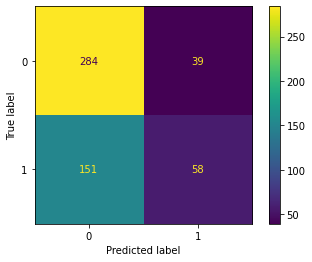

In [88]:
plot_confusion_matrix(MLP_best,X_test_scaled,y_test_val)

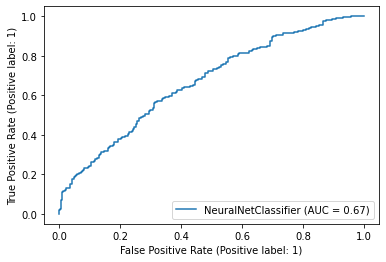

In [89]:
plot_roc_curve(MLP_best,X_test_scaled,y_test_val)

In [90]:
# final_MLP_model = MLP_best.predict(X_test)

# final_MLP_model_score = accuracy_score(y_test, final_MLP_model)

# print('Final Testing Score on testing data:',final_MLP_model_score)



# Importing Test data and running our final models

In [91]:
X_test = pd.read_csv('X_test_data.csv')
y_test = pd.read_csv('y_test_data.csv')
X_test

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,9.871791,114.371450,27912.908263,8.660269,340.046298,490.451835,8.517762,64.831248,3.652264
1,8.331553,238.992414,11635.772076,3.923239,276.402280,406.245129,15.410764,66.396293,2.692389
2,9.534022,201.955208,9472.614920,6.105708,319.576420,259.636803,15.625617,66.396293,2.768239
3,5.736676,180.290908,12683.483292,7.907877,423.876297,415.006576,12.392869,83.707045,2.741791
4,6.427721,166.850237,12215.409083,7.696751,376.282617,352.745370,20.130483,66.735044,2.904453
...,...,...,...,...,...,...,...,...,...
465,6.363836,207.422436,9844.702293,9.765921,320.630725,466.592544,19.156261,58.265305,4.038984
466,7.080795,138.525712,17905.480019,7.929303,399.503611,485.423179,17.667366,36.058262,5.437429
467,8.832142,176.808661,12171.024549,7.475336,321.257628,395.387337,12.481552,65.867189,3.914512
468,7.080795,181.374651,14579.822073,5.435058,333.775777,308.792515,9.545092,60.214647,4.161749


In [92]:
y_test

,Potability
0,0
1,0
2,0
3,1
4,1
...,...
465,0
466,1
467,1
468,0


# Standardise the test data set

In [93]:
scs = StandardScaler()
X_test = scs.fit_transform(X_test)


## SVM Final Model

In [94]:
%%time

test_final_SVC = best_SVC_model.predict(X_test)
test_final_SVC_score = accuracy_score(y_test, test_final_SVC)

# Calculating the test score
print('Final Model Testing score:',test_final_SVC_score)

Final Model Testing score: 0.6893617021276596
CPU times: user 24 ms, sys: 785 µs, total: 24.8 ms
Wall time: 24.2 ms


In [95]:
print(classification_report(y_test,test_final_SVC, zero_division = True))

              precision    recall  f1-score   support

           0       0.70      0.90      0.79       304
           1       0.62      0.31      0.41       166

    accuracy                           0.69       470
   macro avg       0.66      0.60      0.60       470
weighted avg       0.67      0.69      0.66       470



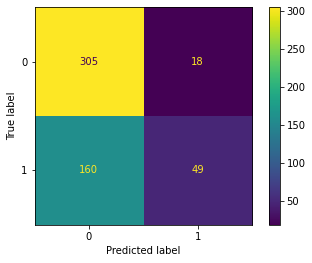

In [96]:
plot_confusion_matrix(SVC_scaled_model,X_test_scaled,y_test_val);

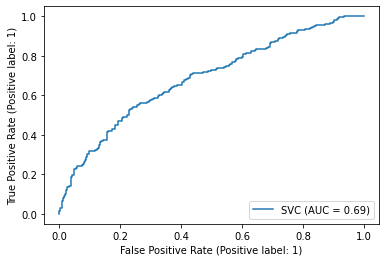

In [97]:
plot_roc_curve(SVC_scaled_model,X_test_scaled,y_test_val);

## MLP Final Model

In [98]:
X_test = torch.tensor(X_test)
y_train = torch.tensor(np.array(y_train))


In [99]:
test_final_MLP = MLP_best.predict(X_test.float())

pred_final_MLP = accuracy_score(y_test, test_final_MLP)

print('Final Testing Score on train data:',pred_final_MLP)

Final Testing Score on train data: 0.7


In [100]:
print(classification_report(y_test,test_final_MLP, zero_division = True))

              precision    recall  f1-score   support

           0       0.72      0.88      0.79       304
           1       0.62      0.38      0.47       166

    accuracy                           0.70       470
   macro avg       0.67      0.63      0.63       470
weighted avg       0.69      0.70      0.68       470



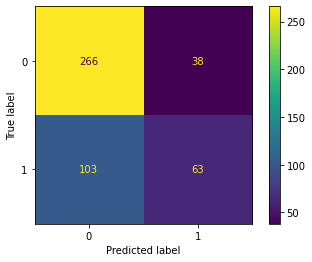

In [101]:
plot_confusion_matrix(MLP_best,X_test.float(),y_test);

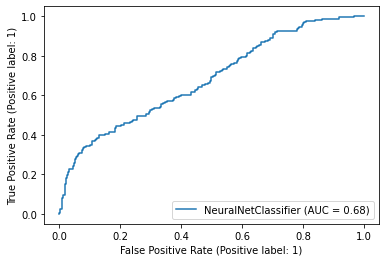

In [102]:
plot_roc_curve(MLP_best,X_test.float(),y_test);

Final Results from both the models

# 